知识图谱是个很复杂的概念，但一般其中的知识都是以RDF三元组的形式存储的，所以我在这里实际上演示的是pyDatalog与RDF类三元组的交互。

话说东汉末年，群雄并起，其中一支号称汉室宗亲，这正是我们熟悉的刘备刘皇叔了。刘备自称中山靖王之后，而这一点在近代保守质疑。假如这一点被推翻，刘备及其后代的宗亲身份，获得的名望和资源，以皇帝身份匡扶汉室的正统性就都不成立了。

这里存在着一个逻辑链和许多关系。关系的表达是知识图谱的长处，而逻辑链的建立和维护则是Datalog的优势。所以我就以这个作为例子，演示pyDatalog与知识图谱的交互。

In [3]:
!cat father_son.ttl

@prefix : <http://www.blmoistawinde.org/example1#>.

:ZhongShanJingWang :IsA :ZongQin .

:LiuBei :FatherOf :LiuShan.

In [4]:
#coding=utf-8
from pyDatalog import pyDatalog
from pyDatalog.pyDatalog import assert_fact, retract_fact, load, ask
import rdflib
from rdflib import Literal

pyDatalog.create_terms('X,Y,R,relation')
prefix0 = "http://www.blmoistawinde.org/example1#" # URI的统一前缀
abbr = lambda x: x[len(prefix0):]                  # 取URI的缩写，为了展示的简洁
verbose = lambda x: prefix0+x                      # 恢复缩写为URI的全称

g = rdflib.Graph()
g.parse("father_son.ttl", format="turtle")
print("original data:")
for subj, pred, obj in g:          #从RDF取出三元组
    print(abbr(subj),abbr(pred), abbr(obj))
    assert_fact("relation",abbr(subj),abbr(pred), abbr(obj))     #加入Datalog数据库
load("relation(X,'GrandfatherOf',Z) <= relation(X,'FatherOf',Y) & relation(Y,'FatherOf',Z)")

original data:
LiuBei FatherOf LiuShan
ZhongShanJingWang IsA ZongQin


In [5]:
print(relation(X,R,Y))

X                 | R        | Y      
------------------|----------|--------
LiuBei            | FatherOf | LiuShan
ZhongShanJingWang | IsA      | ZongQin


上面是已知的知识。然后，假设刘备是中山靖王之后，那么他和他的子孙就一下得到了绵延的荣光（逻辑链的自动推理）：

In [6]:
load("+ relation('ZhongShanJingWang','FatherOf','LiuBei')")
load("relation(Y,'IsA','ZongQin') <= relation(X,'IsA','ZongQin') & relation(X,'FatherOf',Y)")
print(relation(X,R,Y))

X                 | R             | Y      
------------------|---------------|--------
LiuBei            | FatherOf      | LiuShan
ZhongShanJingWang | IsA           | ZongQin
ZhongShanJingWang | GrandfatherOf | LiuShan
ZhongShanJingWang | FatherOf      | LiuBei 
LiuShan           | IsA           | ZongQin
LiuBei            | IsA           | ZongQin


我们可以把更新后的Datalog数据库写入RDF：

In [7]:
g2 = rdflib.Graph()

for i in range(len(X.data)):
    subj, pred, obj = verbose(X.data[i]),verbose(R.data[i]),verbose(Y.data[i])
    record = (Literal(subj),Literal(pred),Literal(obj))
    g2.add(record)

print("saved data:")
for subj, pred, obj in g2:          #从RDF取出三元组
    print(abbr(subj),abbr(pred), abbr(obj))

# 用这些语句就可以保存到文件
# str0 = str(g2.serialize(format='turtle')) 
# open("someFile.ttl","w").write(str0)

saved data:
LiuShan IsA ZongQin
LiuBei FatherOf LiuShan
ZhongShanJingWang IsA ZongQin
ZhongShanJingWang FatherOf LiuBei
LiuBei IsA ZongQin
ZhongShanJingWang GrandfatherOf LiuShan


也可以利用networkX+matplotlib对知识图谱进行可视化：

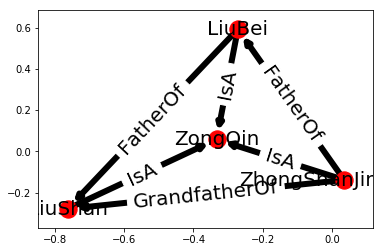

In [9]:
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline

relation(X,R,Y)
g_nx = nx.MultiDiGraph()
labels = {}
for i in range(len(X.data)):
    subj, pred, obj = X.data[i],R.data[i],Y.data[i]
    g_nx.add_edge(subj,obj)
    labels[(subj,obj)] = pred      #其实可能有多个关系，但这边先只取一个
pos=nx.spring_layout(g_nx)
pos['ZongQin'] = (pos['LiuBei']+pos['LiuShan']+pos['ZhongShanJingWang'])/3.0
nx.draw_networkx_nodes(g_nx, pos, node_size=300)
nx.draw_networkx_edges(g_nx,pos,width=6)
nx.draw_networkx_labels(g_nx,pos,font_size=20,font_family='sans-serif')
nx.draw_networkx_edge_labels(g_nx, pos, labels , font_size=20, font_family='sans-serif')
plt.show()

让我们再推翻刘备是中山靖王之后的这个事实，我们也可以看到其带来的雪崩式的效应：

In [10]:
load("-relation('ZhongShanJingWang','FatherOf','LiuBei')")
print(relation(X,R,Y))
new_relations = [(X.data[i],R.data[i],Y.data[i]) for i in range(len(X.data))]
for subj,pred,obj in g2:
    subj,pred,obj = abbr(subj),abbr(pred), abbr(obj)
    if not (subj,pred,obj) in new_relations:
        print("Fact: %s,%s,%s overturned!"%(subj,pred,obj))

X                 | R        | Y      
------------------|----------|--------
LiuBei            | FatherOf | LiuShan
ZhongShanJingWang | IsA      | ZongQin
Fact: LiuShan,IsA,ZongQin overturned!
Fact: ZhongShanJingWang,FatherOf,LiuBei overturned!
Fact: LiuBei,IsA,ZongQin overturned!
Fact: ZhongShanJingWang,GrandfatherOf,LiuShan overturned!


一个事实的变化可能导致整个逻辑链的改变。但由于人类记忆力的限制，从一点而顾及到整条链，甚至是很多相关的逻辑链，可能是人类难以顾及的。而Datalog这样基于逻辑的又“即插即用”的声明式语言，在应对这些问题时可能就很有优势了。

对知识图谱有一定了解后就会知道，单纯的RDF的表达力还是比较有限的，这时我们可能就要融入OWL。OWL的表示方法更加复杂，所以我并没有实现与真正OWL的交互，而是借鉴了OWL中的一部分表示方法，修改完善后应当可以直接用于OWL。就在这里呈现一种可行性吧：

In [11]:
# 加入更复杂的逻辑，进行一致性的检验，在“加法”后也能“消除”不一致的关系
# 1.互不相交的关系同时成立是不可能的
pyDatalog.clear()
load("relation(X,'Impossible',Y) <= relation(X,R1,Y) & relation(X,R2,Y) & relation(R1,'propertyDisjointWith',R2)")
load("+ relation('FatherOf','propertyDisjointWith','MotherOf')")
load("+ relation('xiaoming','FatherOf','xianghong')")
load("+ relation('xiaoming','MotherOf','xianghong')")
print(relation(X,'Impossible',Y))
for i in range(len(X.data)):               #如果出现不可能的关系，就把相应的两个对象之间的关系都删除
    x0,y0 = X.data[i], Y.data[i]
    relation(x0,R,y0)
    for r0 in R.data:
        retract_fact('relation',x0,r0,y0)
        print("retract_fact:(%s, %s, %s)" % (x0,r0,y0))

X        | Y        
---------|----------
xiaoming | xianghong
retract_fact:(xiaoming, Impossible, xianghong)
retract_fact:(xiaoming, FatherOf, xianghong)
retract_fact:(xiaoming, MotherOf, xianghong)


In [12]:
pyDatalog.clear()
# 2.同一个类不可能同时属于两个不相交的类
load("relation(X,'subClassOf','Nothing') <= relation(X,'subClassOf',C1) & relation(X,'subClassOf',C2) & relation(C1,'disjointWith',C2)")
load("+ relation('GoodPerson','disjointWith','BadPerson')")
load("+ relation('xiaoming','subClassOf','GoodPerson')")
load("+ relation('xiaoming','subClassOf','BadPerson')")
print(relation(X,'subClassOf','Nothing'))
for i in range(len(X.data)):               #如果出现不可能的类，就把相应的类和与其相关的关系都删除
    x0 = X.data[i]
    relation(x0,R,Y)
    for j in range(len(R.data)):
        r0,y0 = R.data[j], Y.data[j]
        retract_fact('relation',x0,r0,y0)
        print("retract_fact:(%s, %s, %s)" % (x0,r0,y0))

X       
--------
xiaoming
retract_fact:(xiaoming, subClassOf, Nothing)
retract_fact:(xiaoming, subClassOf, BadPerson)
retract_fact:(xiaoming, subClassOf, GoodPerson)
